### Data Collection

In [303]:
import numpy as np
import pandas
from bs4 import BeautifulSoup
import requests
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily
from geopy.geocoders import Nominatim

In [4]:
base_url = "https://www.racing-reference.info/"
driver_url = "https://www.racing-reference.info/driver/Jimmie_Johnson/"

In [5]:
r = requests.get(driver_url)
r.status_code

200

In [7]:
soup = BeautifulSoup(r.content, "html.parser")

In [168]:
cells = soup.select(".tb:nth-child(3) .even .col , .tb:nth-child(3) .odd .col")
table = []
for i in range(20):
    row = []
    for j in range(17):
        row.append(cells[i * 17 + j].text)
    row.append(cells[i * 17].find("a")["href"])
    table.append(row)
seasons = pd.DataFrame(table)
seasons.drop([0, 19], inplace=True)
seasons.reset_index(inplace=True, drop=True)
seasons.rename(columns={0 : "year", 1 : "age", 2 : "completed", 3 : "win", 4 : "t5", 5 : "t10", 6 : "pole", 7: "laps", 8 : "led", 9 : "earnings", 10: "rank", 11 : "avg_start", 12: "avg_finish", 13: "running_at_finish", 14 : "lead_lap_finishes", 15: "dnq", 16: "withdrew", 17 : "href"}, inplace=True)
seasons

,year,age,completed,win,t5,t10,pole,laps,led,earnings,rank,avg_start,avg_finish,running_at_finish,lead_lap_finishes,dnq,withdrew,href
0,2002,26,36 of 36,3,6,21,4,10521,838,"3,788,268",5,14.3,13.5,33,25,0,0,/season-stats/2002/W
1,2003,27,36 of 36,3,14,20,2,10492,644,"7,745,530",2,12.3,11.4,33,29,0,0,/season-stats/2003/W
2,2004,28,36 of 36,8,20,23,1,10054,1312,"8,275,721",2,10.5,12.1,29,27,0,0,/season-stats/2004/W
3,2005,29,36 of 36,4,13,22,1,10126,547,"8,336,712",5,12.2,12.7,31,28,0,0,/season-stats/2005/W
4,2006,30,36 of 36,5,13,24,1,10577,854,"15,875,125",1,10.8,9.7,35,31,0,0,/season-stats/2006/W
5,2007,31,36 of 36,10,20,24,4,10318,1290,"15,313,920",1,9.8,10.8,32,26,0,0,/season-stats/2007/W
6,2008,32,36 of 36,7,15,22,6,10643,1959,"15,170,464",1,8.5,10.5,35,29,0,0,/season-stats/2008/W
7,2009,33,36 of 36,7,16,24,4,10298,2238,"14,388,237",1,8.3,11.1,35,30,0,0,/season-stats/2009/W
8,2010,34,36 of 36,6,17,23,2,10418,1315,"13,393,186",1,9.4,12.2,32,27,0,0,/season-stats/2010/W
9,2011,35,36 of 36,2,14,21,0,10560,1115,"7,599,034",6,12.9,11.9,34,29,0,0,/season-stats/2011/W


In [125]:
races = DataFrame()
for index, row in tqdm(seasons[["year", "href"]].iterrows(), total=18):
    href = row["href"]
    season = row["year"]
    url = base_url + href.strip("/")
    r = requests.get(url)
    season_soup = BeautifulSoup(r.content, "html.parser")
    cells = season_soup.select(".table-row div")
    table = []
    for i in range(36):
        row = [season]
        for j in range(17):
            row.append(cells[i * 17 + j].text)
        row.append(cells[i * 17].find("a")["href"])
        table.append(row)
    race = pd.DataFrame(table)
    race.drop(columns=[6], inplace=True)
    race.rename(columns={0 : "season", 1 : "race_number", 2 : "date", 3 : "site", 4 : "cars", 5: "winner", 7 : "start", 8 : "make/model", 9 : "len", 10 : "sfc", 11 : "miles", 12 : "purse", 13 : "pole", 14: "cautions", 15 : "caution_laps", 16 : "speed", 17 : "lc", 18 : "href"}, inplace=True)
    races = pd.concat([races, race]).reset_index().drop(columns=["index"])
races.reset_index(inplace=True)

  0%|          | 0/18 [00:00<?, ?it/s]

In [126]:
races

,index,season,race_number,date,site,cars,winner,start,make/model,len,sfc,miles,purse,pole,cautions,caution_laps,speed,lc,href
0,0,2002,1,02/17/02,Daytona,43,Ward Burton,19,Dodge,2.500,P,500,"10,573,184",185.831,9,38,142.971,20,https://www.racing-reference.info/race-results...
1,1,2002,2,02/24/02,Rockingham,43,Matt Kenseth,25,Ford,1.017,P,400,"2,949,536",156.008,10,57,115.478,17,https://www.racing-reference.info/race-results...
2,2,2002,3,03/03/02,Las Vegas,43,Sterling Marlin,24,Dodge,1.500,P,401,"4,137,735",172.850,6,25,136.754,22,https://www.racing-reference.info/race-results...
3,3,2002,4,03/10/02,Atlanta,43,Tony Stewart,9,Pontiac,1.540,P,501,"2,911,575",191.542,7,37,148.443,34,https://www.racing-reference.info/race-results...
4,4,2002,5,03/17/02,Darlington,43,Sterling Marlin,11,Dodge,1.366,P,400,"2,834,398",170.089,5,40,126.070,11,https://www.racing-reference.info/race-results...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,643,2019,32,10/20/19,Kansas,40,Denny Hamlin,23,Toyota,1.500,P,416,,178.047,7,32,136.491,15,https://www.racing-reference.info/race-results...
644,644,2019,33,10/27/19,Martinsville,38,"Martin Truex, Jr.",3,Toyota,0.526,P,263,,97.840,11,69,75.448,3,https://www.racing-reference.info/race-results...
645,645,2019,34,11/03/19,Fort Worth,40,Kevin Harvick,1,Ford,1.500,P,501,,189.707,11,56,133.759,26,https://www.racing-reference.info/race-results...
646,646,2019,35,11/10/19,Phoenix,39,Denny Hamlin,3,Toyota,1.000,P,312,,140.116,5,32,111.429,8,https://www.racing-reference.info/race-results...


In [230]:
standings = DataFrame()
for index, row in tqdm(races[["index", "season", "href"]].iterrows(), total=len(races["index"])):
    url = row["href"]
    race_id = row["index"]
    r = requests.get(url)
    if r.status_code != 200:
        print("it broke")
        break
    standing_soup = BeautifulSoup(r.content, "html.parser")
    cells = standing_soup.select(".race-results-tbl td")
    table = []
    if int(row["season"]) == 2016:
        n = 10
    else:
        n = 11
    for i in range(len(cells) // n):
        row_proto = [race_id]
        for j in range(n):
            row_proto.append(cells[i * n + j].text)
        if int(row["season"]) > 2016:
            row_proto.pop()
            row_proto.insert(11, 0)
        if n == 10:
            row_proto.insert(11, 0)
        table.append(row_proto)
    standing = pd.DataFrame(table)
    standing.rename(inplace=True, columns={0 : "race_id", 1 : "place", 2 : "start", 3 : "number", 4 : "driver", 5 : "sponsor", 6 : "car", 7 : "laps", 8 : "money", 9 : "status", 10 : "led", 11 : "pts"})
    standings = pd.concat([standings, standing]).reset_index().drop(columns=["index"])
standings.reset_index(inplace=True)
standings.drop(columns=["money", "status", "led", "pts"], inplace=True)

  0%|          | 0/648 [00:00<?, ?it/s]

In [239]:
standings

,index,race_id,place,start,number,driver,sponsor,car,laps
0,0,0,1,19,22,Ward Burton,Caterpillar (Bill Davis),Dodge,200
1,1,0,2,41,21,Elliott Sadler,Motorcraft (Wood Brothers),Ford,200
2,2,0,3,35,09,Geoffrey Bodine,Miccosukee Indian Gaming (James Finch),Ford,200
3,3,0,4,15,97,Kurt Busch,Rubbermaid (Jack Roush),Ford,200
4,4,0,5,4,15,Michael Waltrip,"NAPA / DEI 20 Years (Dale Earnhardt, Inc.)",Chevrolet,200
...,...,...,...,...,...,...,...,...,...
27295,27295,647,36,38,52,Josh Bilicki,Travis Mills Foundation (Rick Ware),Ford,240
27296,27296,647,37,35,77,Reed Sorenson,Rousseau / Quartz (Spire Motorsports),Chevrolet,236
27297,27297,647,38,32,15,Joe Nemechek,RoyalTeakCollection.com (Jay Robinson),Chevrolet,227
27298,27298,647,39,9,24,William Byron,Axalta Flames of Independence (Rick Hendrick),Chevrolet,215


### Data Cleaning

In [259]:
def string_clean(s):
    out = ""
    for c in s:
        if ord(c) >= 32 and ord(c) <= 126:
            out += c
    out = out.strip()
    return out
vec_string_clean = np.vectorize(string_clean)

In [260]:
clean_seasons = seasons.copy()

rem_commas = np.vectorize(lambda x : x.replace(",", ""))
clean_seasons["earnings"] = rem_commas(seasons["earnings"])

numerics = ['year', 'age', 'win', 't5', 't10', 'pole', 'laps', 'led', 'earnings', 'rank', 'avg_start', 'avg_finish', 'running_at_finish', 'lead_lap_finishes', 'dnq', 'withdrew']
for col in numerics:
    clean_seasons[col] = pd.to_numeric(clean_seasons[col])

strings = ["completed", "href"]
for col in strings:
    clean_seasons[col] = vec_string_clean(clean_seasons[col])
clean_seasons.dtypes

year                   int64
age                    int64
completed             object
win                    int64
t5                     int64
t10                    int64
pole                   int64
laps                   int64
led                    int64
earnings               int64
rank                   int64
avg_start            float64
avg_finish           float64
running_at_finish      int64
lead_lap_finishes      int64
dnq                    int64
withdrew               int64
href                  object
dtype: object

In [270]:
clean_races = races.copy()
clean_races["purse"] = rem_commas(races["purse"])
numerics = ['index', 'season', 'race_number', 'cars', 'start', 'len', 'miles', 'purse', 'pole', 'cautions', 'caution_laps', 'speed', 'lc']
for col in numerics:
    clean_races[col] = pd.to_numeric(clean_races[col], errors="coerce")
clean_races["date"] = pd.to_datetime(clean_races["date"])
strings = ["site", "winner", "make/model", "sfc", "href"]
for col in strings:
    clean_races[col] = vec_string_clean(clean_races[col])
clean_races.rename(inplace=True, columns={"index" : "race_id"})
clean_races.dtypes

race_id                  int64
season                   int64
race_number              int64
date            datetime64[ns]
site                    object
cars                     int64
winner                  object
start                    int64
make/model              object
len                    float64
sfc                     object
miles                    int64
purse                  float64
pole                   float64
cautions                 int64
caution_laps             int64
speed                  float64
lc                       int64
href                    object
dtype: object

In [264]:
clean_standings = standings.copy()
numerics = ['index', 'race_id', 'place', 'start', 'number', 'laps']
for col in numerics:
    clean_standings[col] = pd.to_numeric(clean_standings[col])
strings = ["driver", "sponsor", "car"]
for col in strings:
    clean_standings[col] = vec_string_clean(clean_standings[col])
clean_standings.dtypes

index       int64
race_id     int64
place       int64
start       int64
number      int64
driver     object
sponsor    object
car        object
laps        int64
dtype: object

In [265]:
seasons.isna().any().any() or races.isna().any().any() or standings.isna().any().any()

False

In [324]:
site_lookup = {'Daytona' : 'Daytona Beach', 'Rockingham' : 'Rockingham', 'Las Vegas' : 'Las Vegas', 'Atlanta' : 'Atlanta', 'Darlington' : 'Darlington South Carolina', 'Bristol' : 'Bristol TN', 'Fort Worth' : 'Fort Worth', 'Martinsville' : 'Martinsville', 'Talladega' : 'Talladega', 'Fontana' : 'Fontana', 'Richmond' : 'Richmond', 'Charlotte' : 'Charlotte', 'Dover' : 'Dover DE', 'Pocono' : 'Pocono', 'Michigan' : 'Brooklyn Michigan', 'Sonoma' : 'Sonoma', 'Chicago' : 'Chicago', 'Loudon' : 'Loudon', 'Indianapolis' : 'Indianapolis', 'Watkins Glen' : 'Watkins Glen', 'Kansas' : 'Kansas City KS', 'Phoenix' : 'Phoenix', 'Homestead' : 'Homestead', 'Kentucky' : 'Sparta Kentucky', 'Charlotte (Road)' : 'Charlotte'}
loc = Nominatim(user_agent="GetLoc")
site_coords = {}
for site in clean_races["site"].unique():
    getLoc = loc.geocode(site_lookup[site])
    site_coords[site] = (getLoc.latitude, getLoc.longitude)
site_coords

{'Daytona': (29.2108147, -81.0228331),
 'Rockingham': (36.3926798, -79.744144),
 'Las Vegas': (36.1672559, -115.148516),
 'Atlanta': (33.7489924, -84.3902644),
 'Darlington': (34.3609331, -79.9438572),
 'Bristol': (36.5945034, -82.1885212),
 'Fort Worth': (32.753177, -97.3327459),
 'Martinsville': (36.6915262, -79.8725386),
 'Talladega': (33.3967079, -86.1597137),
 'Fontana': (34.0922335, -117.435048),
 'Richmond': (37.5385087, -77.43428),
 'Charlotte': (35.2272086, -80.8430827),
 'Dover': (39.158168, -75.5243682),
 'Pocono': (47.246587, -116.0487687),
 'Michigan': (42.105874, -84.2482819),
 'Sonoma': (38.5110803, -122.8473388),
 'Chicago': (41.8755616, -87.6244212),
 'Loudon': (35.7490023, -84.320293),
 'Indianapolis': (39.7683331, -86.1583502),
 'Watkins Glen': (42.3810555, -76.8705777),
 'Kansas': (39.1134562, -94.626497),
 'Phoenix': (33.4484367, -112.074141),
 'Homestead': (25.4718946, -80.4759905),
 'Kentucky': (38.6880765, -84.89880439767657),
 'Charlotte (Road)': (35.2272086, -

In [359]:
weather = DataFrame()
for d, s in tqdm(clean_races[["date", "site"]].values):
    location = Point(*site_coords[s])
    data = Daily(location, d, d)
    data = data.fetch()
    data["site"] = s
    weather = pd.concat([weather, data.reset_index()]).reset_index(drop=True)
weather

  0%|          | 0/648 [00:00<?, ?it/s]

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,site,station,index
0,2002-02-17,14.4,7.2,21.1,0.0,NaN,NaN,10.4,NaN,NaN,0.0,Daytona,NaN,NaN
1,2002-03-03,6.1,-0.6,12.8,0.0,0.0,NaN,10.4,NaN,1029.8,NaN,Las Vegas,NaN,NaN
2,2002-03-10,7.2,1.7,12.2,0.0,0.0,323.0,27.0,NaN,1029.2,NaN,Atlanta,NaN,NaN
3,2002-03-17,17.3,11.7,20.6,NaN,NaN,NaN,12.7,NaN,1020.5,NaN,Darlington,NaN,NaN
4,2002-03-24,7.2,-5.0,18.9,0.0,0.0,NaN,5.8,NaN,1019.4,0.0,Bristol,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2019-10-20,13.4,7.2,19.4,3.3,0.0,140.0,10.7,NaN,1007.4,NaN,Kansas,NaN,NaN
511,2019-10-27,20.5,11.6,26.7,NaN,NaN,NaN,4.9,NaN,NaN,NaN,Martinsville,NaN,NaN
512,2019-11-03,11.1,2.8,19.4,0.0,0.0,NaN,14.0,NaN,1020.8,NaN,Fort Worth,NaN,NaN
513,2019-11-10,23.6,16.1,30.6,0.0,0.0,141.0,5.8,NaN,1011.8,NaN,Phoenix,NaN,NaN


In [361]:
clean_weather = weather.copy()
numerics = ['tavg', 'tmin', 'prcp', 'snow', 'wdir', 'wspd', "wpgt", "pres", "tsun"]
for col in numerics:
    clean_weather[col] = pd.to_numeric(clean_weather[col])
clean_weather["prcp"].fillna(value=0.0, inplace=True)
clean_weather.rename(columns={"time" : "date"}, inplace=True)
clean_weather["date"] = pd.to_datetime(clean_weather["date"])
clean_weather

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,site,station,index
0,2002-02-17,14.4,7.2,21.1,0.0,NaN,NaN,10.4,NaN,NaN,0.0,Daytona,NaN,NaN
1,2002-03-03,6.1,-0.6,12.8,0.0,0.0,NaN,10.4,NaN,1029.8,NaN,Las Vegas,NaN,NaN
2,2002-03-10,7.2,1.7,12.2,0.0,0.0,323.0,27.0,NaN,1029.2,NaN,Atlanta,NaN,NaN
3,2002-03-17,17.3,11.7,20.6,0.0,NaN,NaN,12.7,NaN,1020.5,NaN,Darlington,NaN,NaN
4,2002-03-24,7.2,-5.0,18.9,0.0,0.0,NaN,5.8,NaN,1019.4,0.0,Bristol,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2019-10-20,13.4,7.2,19.4,3.3,0.0,140.0,10.7,NaN,1007.4,NaN,Kansas,NaN,NaN
511,2019-10-27,20.5,11.6,26.7,0.0,NaN,NaN,4.9,NaN,NaN,NaN,Martinsville,NaN,NaN
512,2019-11-03,11.1,2.8,19.4,0.0,0.0,NaN,14.0,NaN,1020.8,NaN,Fort Worth,NaN,NaN
513,2019-11-10,23.6,16.1,30.6,0.0,0.0,141.0,5.8,NaN,1011.8,NaN,Phoenix,NaN,NaN


In [351]:
clean_seasons.to_csv("clean_seasons.csv")
clean_races.to_csv("clean_races.csv")
clean_standings.to_csv("clean_standings.csv")
clean_weather.to_csv("clean_weather.csv")

### Data Visualization

In [283]:
cse = clean_standings.copy()
cr = clean_races.copy()
cst = clean_standings.copy()

In [284]:
cr = cr.drop(columns=["start"]).merge(cst[cst["driver"] == "Jimmie Johnson"].drop(columns="index"), on="race_id", how="inner")
cr

,race_id,season,race_number,date,site,cars,winner,make/model,len,sfc,...,speed,lc,href,place,start,number,driver,sponsor,car,laps
0,0,2002,1,2002-02-17,Daytona,43,Ward Burton,Dodge,2.500,P,...,142.971,20,https://www.racing-reference.info/race-results...,15,1,48,Jimmie Johnson,Lowe's (Rick Hendrick),Chevrolet,199
1,1,2002,2,2002-02-24,Rockingham,43,Matt Kenseth,Ford,1.017,P,...,115.478,17,https://www.racing-reference.info/race-results...,28,11,48,Jimmie Johnson,Lowe's (Rick Hendrick),Chevrolet,390
2,2,2002,3,2002-03-03,Las Vegas,43,Sterling Marlin,Dodge,1.500,P,...,136.754,22,https://www.racing-reference.info/race-results...,6,25,48,Jimmie Johnson,Lowe's (Rick Hendrick),Chevrolet,267
3,3,2002,4,2002-03-10,Atlanta,43,Tony Stewart,Pontiac,1.540,P,...,148.443,34,https://www.racing-reference.info/race-results...,3,15,48,Jimmie Johnson,Lowe's (Rick Hendrick),Chevrolet,325
4,4,2002,5,2002-03-17,Darlington,43,Sterling Marlin,Dodge,1.366,P,...,126.070,11,https://www.racing-reference.info/race-results...,6,5,48,Jimmie Johnson,Lowe's (Rick Hendrick),Chevrolet,293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,643,2019,32,2019-10-20,Kansas,40,Denny Hamlin,Toyota,1.500,P,...,136.491,15,https://www.racing-reference.info/race-results...,10,12,48,Jimmie Johnson,Ally Fueling Futures (Rick Hendrick),Chevrolet,277
644,644,2019,33,2019-10-27,Martinsville,38,"Martin Truex, Jr.",Toyota,0.526,P,...,75.448,3,https://www.racing-reference.info/race-results...,38,24,48,Jimmie Johnson,Ally (Rick Hendrick),Chevrolet,361
645,645,2019,34,2019-11-03,Fort Worth,40,Kevin Harvick,Ford,1.500,P,...,133.759,26,https://www.racing-reference.info/race-results...,34,23,48,Jimmie Johnson,Ally (Rick Hendrick),Chevrolet,199
646,646,2019,35,2019-11-10,Phoenix,39,Denny Hamlin,Toyota,1.000,P,...,111.429,8,https://www.racing-reference.info/race-results...,14,22,48,Jimmie Johnson,Ally (Rick Hendrick),Chevrolet,312


r^2 = 0.004506335839185138


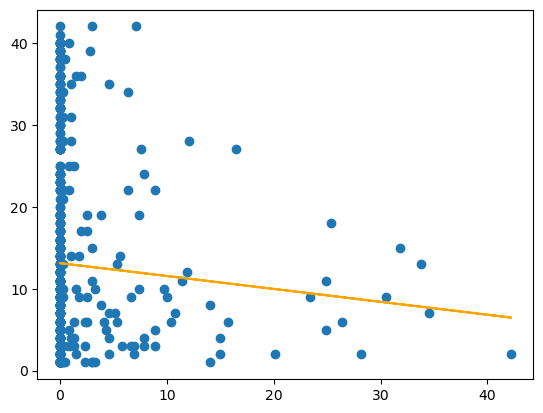

In [416]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import sklearn
temp = cr.merge(clean_weather, on="date")
X = temp["prcp"].values.reshape(-1, 1)
y = temp["place"].values.reshape(-1, 1)

transformer = FunctionTransformer(np.exp, validate=True)

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
r2 = sklearn.metrics.r2_score(y, y_pred)
print(f"r^2 = {r2}")


plt.scatter(X, y)
plt.plot(X, y_pred, color="orange")

,race_id,season,race_number,date,site_x,cars,winner,make/model,len,sfc,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,site_y,station,index
0,0,2002,1,2002-02-17,Daytona,43,Ward Burton,Dodge,2.500,P,...,0.0,NaN,NaN,10.4,NaN,NaN,0.0,Daytona,NaN,NaN
1,2,2002,3,2002-03-03,Las Vegas,43,Sterling Marlin,Dodge,1.500,P,...,0.0,0.0,NaN,10.4,NaN,1029.8,NaN,Las Vegas,NaN,NaN
2,3,2002,4,2002-03-10,Atlanta,43,Tony Stewart,Pontiac,1.540,P,...,0.0,0.0,323.0,27.0,NaN,1029.2,NaN,Atlanta,NaN,NaN
3,4,2002,5,2002-03-17,Darlington,43,Sterling Marlin,Dodge,1.366,P,...,0.0,NaN,NaN,12.7,NaN,1020.5,NaN,Darlington,NaN,NaN
4,5,2002,6,2002-03-24,Bristol,43,Kurt Busch,Ford,0.533,P,...,0.0,0.0,NaN,5.8,NaN,1019.4,0.0,Bristol,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,643,2019,32,2019-10-20,Kansas,40,Denny Hamlin,Toyota,1.500,P,...,3.3,0.0,140.0,10.7,NaN,1007.4,NaN,Kansas,NaN,NaN
511,644,2019,33,2019-10-27,Martinsville,38,"Martin Truex, Jr.",Toyota,0.526,P,...,0.0,NaN,NaN,4.9,NaN,NaN,NaN,Martinsville,NaN,NaN
512,645,2019,34,2019-11-03,Fort Worth,40,Kevin Harvick,Ford,1.500,P,...,0.0,0.0,NaN,14.0,NaN,1020.8,NaN,Fort Worth,NaN,NaN
513,646,2019,35,2019-11-10,Phoenix,39,Denny Hamlin,Toyota,1.000,P,...,0.0,0.0,141.0,5.8,NaN,1011.8,NaN,Phoenix,NaN,NaN


In [316]:
print("{", end="")
for site in list(cr["site"].unique()):
    print(f"'{site}' : '{site}', ", end="")


{'Daytona' : 'Daytona', 'Rockingham' : 'Rockingham', 'Las Vegas' : 'Las Vegas', 'Atlanta' : 'Atlanta', 'Darlington' : 'Darlington', 'Bristol' : 'Bristol', 'Fort Worth' : 'Fort Worth', 'Martinsville' : 'Martinsville', 'Talladega' : 'Talladega', 'Fontana' : 'Fontana', 'Richmond' : 'Richmond', 'Charlotte' : 'Charlotte', 'Dover' : 'Dover', 'Pocono' : 'Pocono', 'Michigan' : 'Michigan', 'Sonoma' : 'Sonoma', 'Chicago' : 'Chicago', 'Loudon' : 'Loudon', 'Indianapolis' : 'Indianapolis', 'Watkins Glen' : 'Watkins Glen', 'Kansas' : 'Kansas', 'Phoenix' : 'Phoenix', 'Homestead' : 'Homestead', 'Kentucky' : 'Kentucky', 'Charlotte (Road)' : 'Charlotte (Road)', 